In [1]:
import matplotlib.pyplot as plt
import librosa
import torchaudio
import numpy as np
import torch
import torchyin
import torch.nn as nn
from torch.utils.data import DataLoader

import src.utils as utils
import src.models as models
import src.spectrograms as spec
import src.init as init

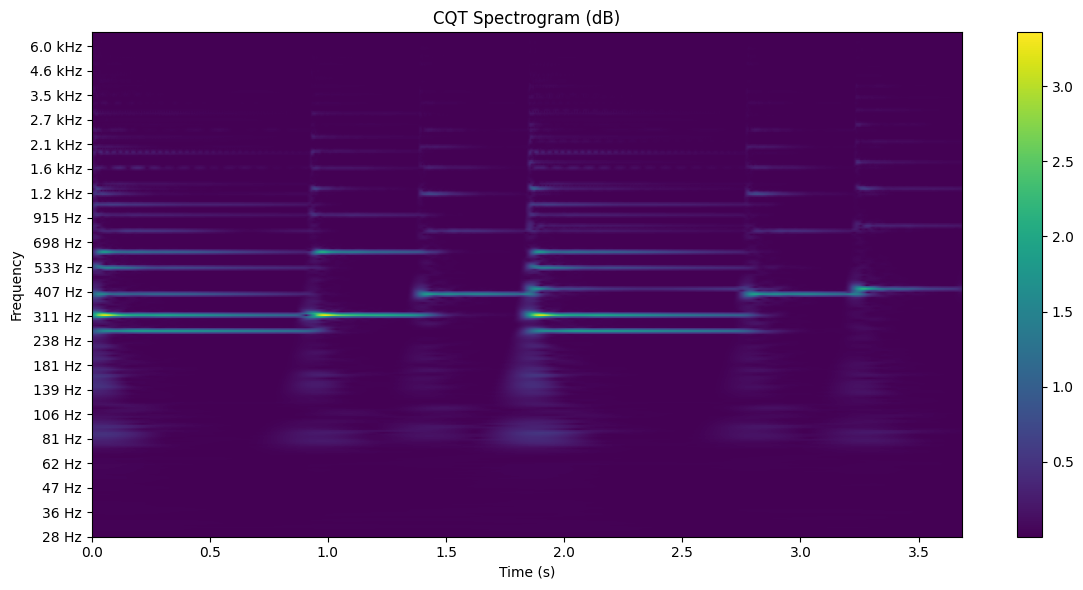

In [2]:
waveform_test, sample_rate_test = torchaudio.load("dataset/audios/test-midi-transcription.wav")
cqt_test, times_test, freq_test = spec.cqt_spec(waveform_test, sample_rate_test, 256)
spec.vis_cqt_spectrogram(cqt_test, times_test, freq_test, 0, times_test[-1])

In [3]:
eps = 1e-5
small = 0.1
a = torch.rand(3,4)-small
b = torch.clamp(a, min=eps)

In [4]:
single_note = "test-data/single-notes"

### Test creating W from single note audio file

In [ ]:
W, freqs = init.init_W(single_note)
# W = spec.max_columns(W)

/Users/edabier/Documents/Stage-Fin-etudes/Stage-Telecom-Paris/AMT_codebase/amt_venv/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=690
  warnings.warn(


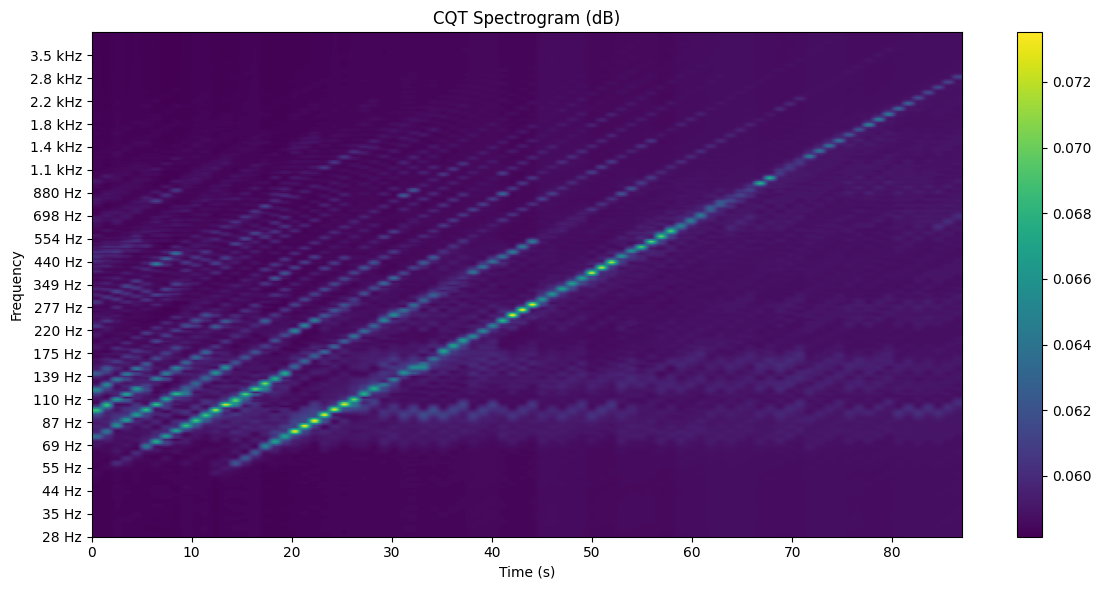

In [11]:
spec.vis_cqt_spectrogram(W, np.arange(W.shape[1]), freqs, 0, W.shape[1])

### Test running MU iterations on a simple example from init W

In [5]:
waveform_test, sample_rate_test = torchaudio.load("dataset/audios/test-midi-transcription.wav")
cqt_test, times_test, freq_test = spec.cqt_spec(waveform_test, sample_rate_test, 256)

# spec.vis_cqt_spectrogram(cqt_test, times_test, freq_test, 0, times_test[-1])
midi, times = spec.midi_to_pianoroll("dataset/midis/test-midi-transcription.mid", waveform_test, times_test, hop_length=128)
onset, offset = utils.detect_onset_offset(midi)

In [6]:
f, t = cqt_test.shape
l = W.shape[1]
n_init_steps = 100

H = init.init_H(l, t, W, cqt_test, n_init_steps, beta=1)

### Test getting MIDI notes from W

In [7]:
pitches, notes, W, H = init.W_to_pitch(W, freqs, H=H)
print(notes, len(notes))

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
        28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
        42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55.,
        56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69.,
        70., 71., 72., 73., 74., 75., 76., 77., 78., 79., 80., 81., 82., 83.,
        84., 85., 86., 87.]) 88


/Users/edabier/Documents/Stage-Fin-etudes/Stage-Telecom-Paris/AMT_codebase/Unrolled-NMF/src/init.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  frequency = torch.tensor(frequency, dtype=torch.float32)


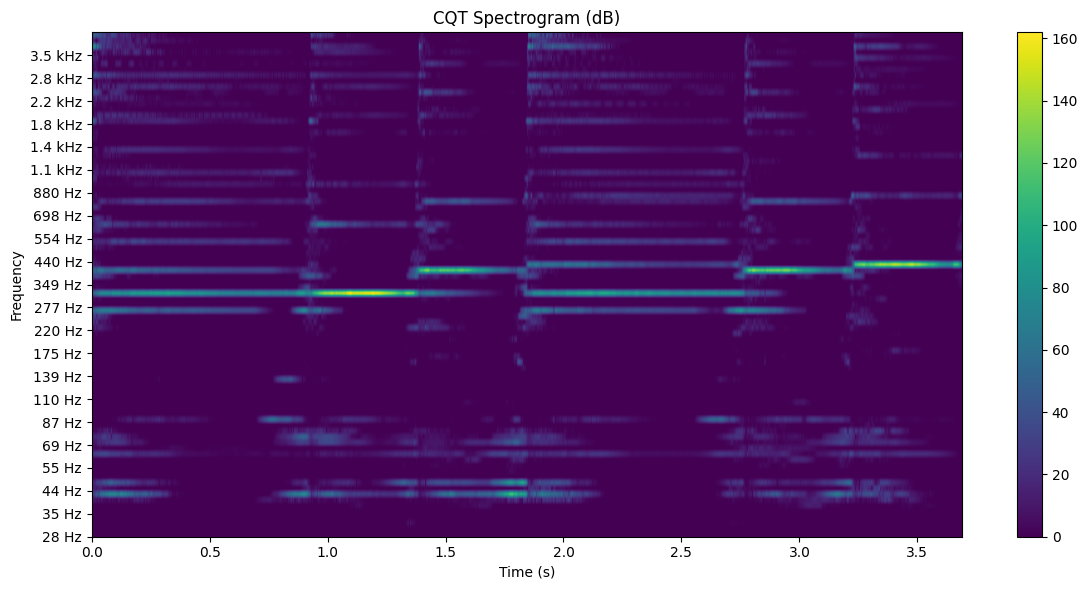

In [8]:
spec.vis_cqt_spectrogram(H, times_test, pitches, 0, 4)

### Test getting MIDI from H

In [9]:
midi_hat, active_midi = init.WH_to_MIDI(W, H, notes, threshold=0.02, smoothing_window=5, adaptative=False, normalize=True)
active_midi

[7, 9, 39, 42, 46, 47, 85]

In [10]:
active_midi = [i for i in range(88) if (midi[i,:]>0).any().item()]
active_midi

[39, 42, 46, 47]

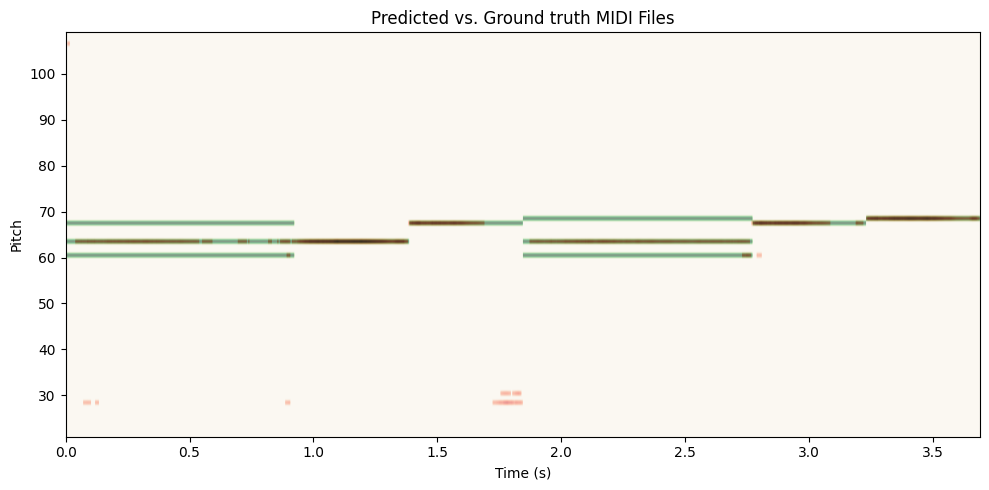

In [11]:
spec.compare_midi(midi, midi_hat, times_test, 0, 4)

In [12]:
criterion = nn.BCELoss()
loss = criterion(midi_hat[active_midi,:], midi[active_midi,:])
loss

tensor(28.6804)

In [34]:
model = models.RALMU2(l, eps, beta=1, W_path=single_note, n_iter=5, shared=True)
device  = torch.device('cpu')
model.to(device=device)
dataset = utils.MaestroNMFDataset("dataset/audios", "dataset/midis")
loader  = DataLoader(dataset, batch_size=1, shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

for M, midi_batch in loader:
    model.init_WH(M)
    M = M.to(device)
    midi_batch = midi_batch.to(device)

    W_hat, H_hat, M_hat = model(M)
    # W_hat, H_hat, M_hat = model.W0, model.H0, M
    _, notes, _, _ = init.W_to_pitch(W_hat, model.freqs, H=H_hat)
    midi_hat, active_midi_hat = init.WH_to_MIDI(W_hat, H_hat, notes, threshold=0.02, smoothing_window=5, adaptative=False, normalize=True)
    # M_hat = M_hat.squeeze(0)
    midi_batch = midi_batch.squeeze(0)
    active_midi = [i for i in range(88) if (midi_batch[i,:]>0).any().item()]
    # print(len(active_midi), len(active_midi_hat))
    # spec.compare_midi(midi, midi_hat, times_test, 0, times_test[-1])
    optimizer.zero_grad()
    loss = criterion(midi_hat[active_midi,:], midi_batch[active_midi,:])
    print(loss)
    loss.backward()
    for param in model.parameters():
        if param.grad is not None:
            print(f"Grad norm: {param.grad.norm().item()}")
        else:
            print(f"Grad is None for {param}")
    optimizer.step()
                    
    print("------------ Next audio file... ------------")

Initialized W and H from files torch.Size([88, 4575]) torch.Size([288, 88])
Cached W and H
tensor(12.2420, grad_fn=<BinaryCrossEntropyBackward0>)
Grad norm: 1.7937554730451666e-06
Grad norm: 5.918045644648373e-06
Grad norm: 2.6625502869137563e-05
Grad norm: 9.2546497398871e-06
Grad norm: 1.432004773960216e-05
Grad norm: 1.5129006897041108e-05
Grad norm: 0.0019823266193270683
Grad norm: 5.140208941156743e-06
Grad norm: 0.008480633608996868
Grad norm: 7.049432952044299e-06
Grad norm: 0.0017975830705836415
Grad norm: 4.073182026331779e-06
------------ Next audio file... ------------
Initialized W and H from files torch.Size([88, 1385]) torch.Size([288, 88])
Cached W and H
tensor(47.1186, grad_fn=<BinaryCrossEntropyBackward0>)
Grad norm: 1.0974304132105317e-05
Grad norm: 1.3980335097585339e-05
Grad norm: 8.783285738900304e-05
Grad norm: 2.551658690208569e-05
Grad norm: 0.00011450792953837663
Grad norm: 5.579800563282333e-05
Grad norm: 0.0003480160085018724
Grad norm: 1.7088714230339974e-05

In [16]:
loss = utils.loss_midi(midi_hat, midi)
loss

tensor(2078.7217)

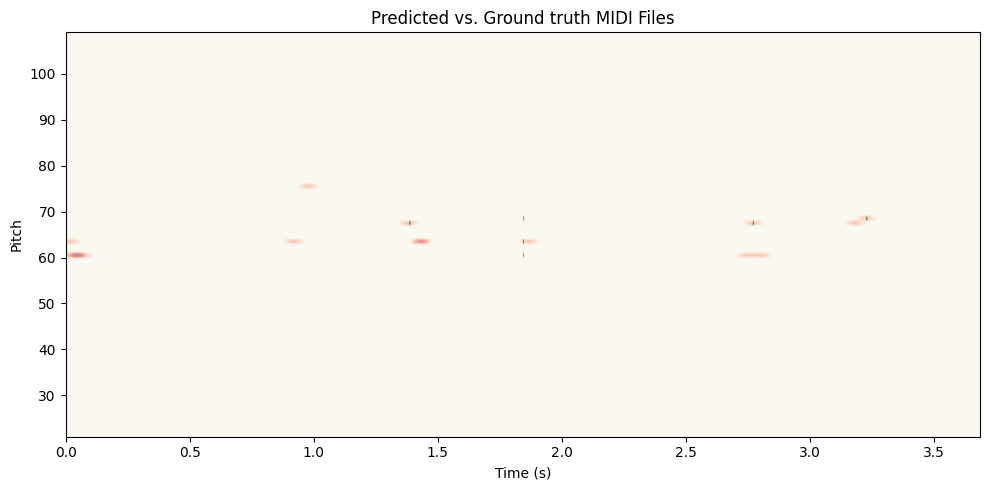

In [12]:
onset_hat, offset_hat = utils.detect_onset_offset(midi_hat, filter=True)
spec.compare_midi(onset,onset_hat, times_test, 0, times_test[-1])

In [ ]:
f0, voiced_flag, voiced_probs = librosa.pyin(y, sr=sr, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
times = librosa.times_like(f0, sr=sr)

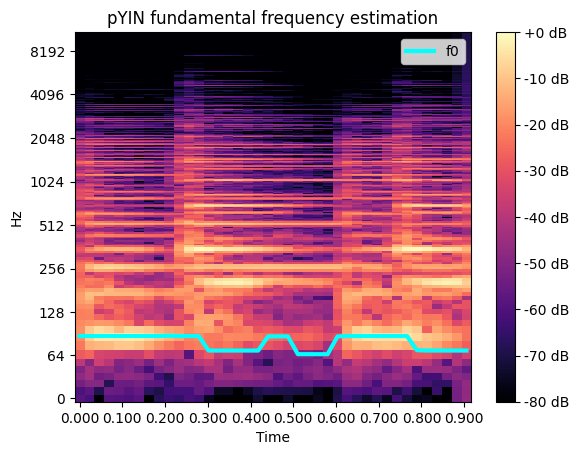

In [ ]:
import matplotlib.pyplot as plt
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
fig, ax = plt.subplots()
img = librosa.display.specshow(D, x_axis='time', y_axis='log', ax=ax)
ax.set(title='pYIN fundamental frequency estimation')
fig.colorbar(img, ax=ax, format="%+2.f dB")
ax.plot(times, f0, label='f0', color='cyan', linewidth=3)
ax.legend(loc='upper right')